In [ ]:
import pickle
import os
from definitions import MEASUREMENTS, TARGETS
def load_pickle(filename):
    with open(filename, "rb") as handle:
        res = pickle.load(handle)
    return res

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from darts import TimeSeries
from copy import deepcopy
from functools import partial
import concurrent.futures
import numpy as np 
from collections import defaultdict

In [2]:
DF = pd.read_pickle('df_dropped.pkl')

In [3]:
MEAS_COLUMNS =['TI-19',
 'FI-16',
 'TI-33',
 'FI-2',
 'FI-151',
 'TI-8',
 'FI-241',
 'FI-38',
 'FI-20',
 'FI-30',
 'TI-3',
 'FI-19',
 'FI-211',
 'FI-11',
 'TI-30',
 'PI-30',
 'TI-1213',
 'TI-4',
 'FI-23',
 'delta_t']

In [4]:
TARGETS.pop(0)

'Carbon dioxide CO2'

In [5]:
SCALER = load_pickle(os.path.join("x_scaler.pkl"))

X = TimeSeries.from_dataframe(DF, value_cols=MEAS_COLUMNS)

X = SCALER.transform(X)

In [6]:
FEAT_NUM_MAPPING = dict(zip(MEAS_COLUMNS, [str(i) for i in range(len(MEAS_COLUMNS))]))

In [6]:
UPDATE_MAPPING = {
    "target": {
        "scaler": load_pickle(os.path.join("y_scaler.pkl")),
        "model": load_pickle(os.path.join( "multivariate_model_new.pkl")),
        "name":TARGETS,
    }
}

[2021-04-12 10:33:58,415] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2021-04-12 10:33:58,416] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[fbprophet] or u8darts[all].


In [7]:
def predict(x, y, model):
    backtest_cov = model.historical_forecasts(
        y,
        covariates=x,
        start=0.05,
        forecast_horizon=1,
        stride=1,
        retrain=False,
        verbose=True,
    )

    return backtest_cov.pd_dataframe()


def run_update(x):

    model_dict = UPDATE_MAPPING["target"]
    y = model_dict["scaler"].transform(
        TimeSeries.from_dataframe(DF, value_cols=model_dict["name"])
    )
    df = predict(x, y, model_dict["model"])
    return df

def run_targets(feature_levels):
    
    df = deepcopy(DF)

    for k, v in feature_levels.items():
        df[k] = df[k] + v/100 * np.abs(df[k])
    
    X_ = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)
    X_ = SCALER.transform(X_)
        
    res = run_update(X_)
    return res


In [186]:
feature_levels = {
    'TI-19': 0
}

In [24]:
results = {}

grid = np.linspace(-100,100,5)

In [25]:
for point in grid:
    results[point] = run_targets({'FI-2': point})

In [28]:
differences = {}

for k, v in results.items():
    differences[k] = np.sum(results[0]["1"] - v['1'])

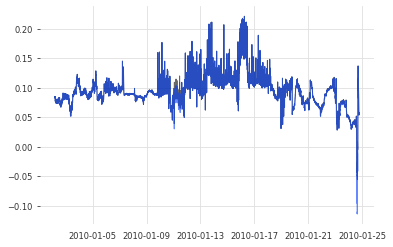

In [44]:
plt.plot(results[0]["0"], alpha=.6, lw=1)
plt.plot(results[-100]["0"], alpha=.6, lw=1)

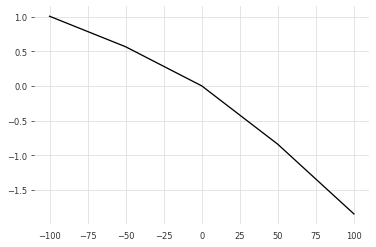

In [29]:
plt.plot(list(differences.keys()), list(differences.values()))

In [10]:
results_double_new = defaultdict(dict)
grid = np.linspace(-100,100,11)

In [11]:
for point_a in grid:
    for point_b in grid:
        results_double_new[point_a][point_b] = run_targets({'TI-19': point_a, 'FI-20': point_b})

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [59]:
from itertools import product

In [17]:
with open('results_double.pkl', "wb") as handle:
    pickle.dump(results_double, handle)

In [48]:
grid = np.linspace(-100,100,21)

In [12]:
image = np.zeros((len(grid), len(grid)))

In [21]:
for i, point_x in enumerate(grid):
    for j, point_y in enumerate(grid):
        image[i][j] = np.sum(results_double_new[0][0]["2"].values[:-100] - results_double_new[point_x][point_y]['2'].values[:-100])

In [22]:
TARGETS

['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 'Ammonia NH3']

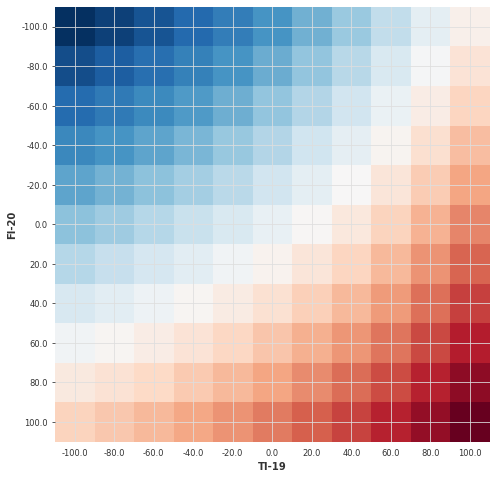

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(image, cmap='RdBu')
plt.xlabel('TI-19')
plt.ylabel('FI-20')
plt.xticks(ticks=np.arange(len(grid)), labels=grid)
plt.yticks(ticks=np.arange(len(grid)), labels=grid)
plt.savefig('ti-19-fi-20_am.pdf', bbox_inches='tight')

In [55]:
TARGETS

['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 'Ammonia NH3']